# Statistical analysis (Single Population) on train

Univariate analysis is perhaps the simplest form of statistical analysis. The key fact is that only one variable is involved.

Bivariate analysis involves the analysis of two variables (often denoted as X, Y), for the purpose of determining the empirical relationship between them.

<center>**For bivariate analysis please use the Statistical analysis (Multiple Populations) variant of this notebook.**</center>

* [Setup and loading the data](#setup)
* [Preprocessing of the data](#preprocessing)
* [Statistical analysis and vizualisation](#general)
* [Single population tests](#tests_single)

<center><strong>Select Cell > Run All to execute the whole analysis</strong></center>

## Setup and dataset loading <a id="setup" /> 

First of all, let's load the libraries that we'll use

In [19]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


//Applications/DataScienceStudio.app/Contents/Resources/kit/python.packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [44]:
import dataiku                               # Access to Dataiku datasets
import pandas as pd 
import numpy as np             # Data manipulation 
from matplotlib import pyplot as plt         # Graphing
import seaborn as sns                        # Graphing
sns.set(style="white")                       # Tuning the style of charts
import warnings                              # Disable some warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
from scipy import stats                      # Stats

The first thing we do is now to load the dataset and put aside the three main types of columns:

* Numerics
* Categorical
* Dates

Statistical analysis requires having the data in memory, we are only going to load a sample of the data. Modify the following cell to change the size of the sample.

In [45]:
dataset_limit = 10000

Load a DSS dataset as a Pandas dataframe

In [46]:
# Take a handle on the dataset
mydataset = dataiku.Dataset("train")

# Load the first lines.
# You can also load random samples, limit yourself to some columns, or only load
# data matching some filters.
#
# Please refer to the Dataiku Python API documentation for more information
df = mydataset.get_dataframe(limit = dataset_limit)

df_orig = df.copy()

# Get the column names
numerical_columns = list(df.select_dtypes(include=[np.number]).columns)
categorical_columns = list(df.select_dtypes(include=[object]).columns)
date_columns = list(df.select_dtypes(include=['<M8[ns]']).columns)

# Print a quick summary of what we just loaded
print "Loaded dataset"
print "   Rows: %s" % df.shape[0]
print "   Columns: %s (%s num, %s cat, %s date)" % (df.shape[1], 
                                                    len(numerical_columns), len(categorical_columns),
                                                    len(date_columns))

Loaded dataset
   Rows: 7395
   Columns: 27 (21 num, 6 cat, 0 date)


In [ ]:
X = my_df.values

# Rescale data
from sklearn.preprocessing import StandardScaler
ss = StandardScaler().fit(X)
X_std = ss.transform(X)

# Apply the PCA transform
from sklearn.decomposition import PCA
sklearn_pca = PCA()
Y_sklearn = sklearn_pca.fit_transform(X_std)

# Plot explained variance by each principal component
plt.bar(range(sklearn_pca.n_components_), sklearn_pca.explained_variance_ratio_, alpha=0.5, align='center',label='individual explained variance')
plt.step(range(sklearn_pca.n_components_), [sklearn_pca.explained_variance_ratio_[:y].sum() for y in range(1,sklearn_pca.n_components_+1)], alpha=0.5, where='mid',label='cumulative explained variance')
plt.axhline(y=0.95, linewidth=2, color = 'r')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.xlim([0, sklearn_pca.n_components_])
plt.legend(loc='best')
plt.tight_layout()

## Preprocessing of the data <a id="preprocessing" />

We will assume that the values are in the first numerical column.

In [47]:
value_col = numerical_columns[0]

Uncomment the following lines to take control on this

In [48]:
#value_col = u'my_value_column'
print "Selected value column is '%s'" % (value_col)

Selected value column is 'urlid'


We impute missing values in the value column

In [49]:
# Use mean for numerical features
v = df[value_col].mean()
if np.isnan(v):
    v = 0
print "Filling value column '%s' with %s" % (value_col, v)
df[value_col] = df[value_col].fillna(v)
df_pop_1 = df[value_col]

Filling value column 'urlid' with 5305.70466531


## Statistical analysis and vizualisation <a id="general" /a>

### General statistics
Number of records, mean, standard deviation, minimal value, quartiles, maximum value, mode, variance, skewness and kurtosis.

In [50]:
additional_stats = ["var", "skew", "kurtosis"]
print "Stats about your series:\n", df_pop_1.describe().append(pd.Series(NaN if df_pop_1.mode().empty else df_pop_1.mode()[0], index=["mode"])).append(pd.Series([df_pop_1.__getattr__(x)() for x in additional_stats], index=additional_stats))

Stats about your series:
count       7.395000e+03
mean        5.305705e+03
std         3.048384e+03
min         1.000000e+00
25%         2.688500e+03
50%         5.304000e+03
75%         7.946500e+03
max         1.056600e+04
mode        1.000000e+00
var         9.292646e+06
skew       -6.676120e-03
kurtosis   -1.195568e+00
dtype: float64


### Histogram
Histograms let you see the number of occurrences in your value column.

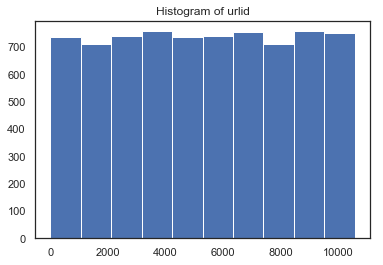

In [51]:
plt.title("Histogram of "+value_col);
plt.hist(df_pop_1);

### Distplot
Distplots combine an histogram with a kernel density estimation.

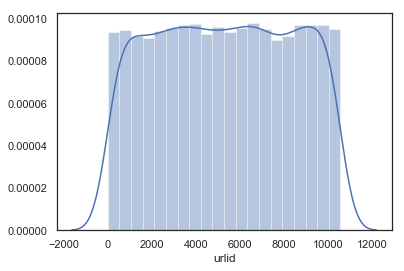

In [52]:
sns.distplot(df_pop_1);

### Box plot

A simple way of representing statistical data on a plot in which a rectangle is drawn to represent the second and third quartiles, with a vertical line inside to indicate the median value. The lower and upper quartiles are shown as horizontal lines either side of the rectangle.

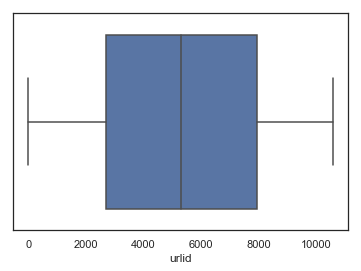

In [53]:
sns.boxplot(df_pop_1);

### Violin plot

The violin plot is similar to box plots, except that they also show the probability density of the data at different values. Violin plots include a marker for the median of the data and a box indicating the interquartile range, as in standard box plots. Overlaid on this box plot is a kernel density estimation. 

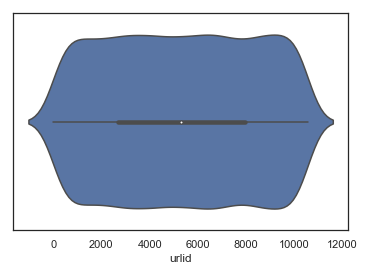

In [54]:
sns.violinplot(df_pop_1);

### Letter value plot

Letter value plots are an improvement upon boxplots for large datasets.

They display the median and the quartiles, like a standard box plot, but will also draw boxes for subsequent "eights", "sixteenth" etc... which are generically called letter values.

A cut off condition will leave a reasonable number of outliers out of the final boxes, helping you spot them easily.

Letter value plots give a good sense of the distribution of data, and of its skewness.

//Applications/DataScienceStudio.app/Contents/Resources/kit/python.packages/seaborn/categorical.py:2612: UserWarning: The `lvplot` function has been renamed to `boxenplot`. The original name will be removed in a future release. Please update your code. 
  warnings.warn(msg)


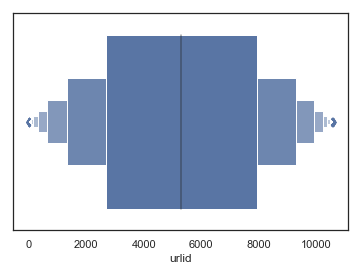

In [55]:
sns.lvplot(df_pop_1);

## Statistical testing <a id="tests" /a>

**Reminder:** For a given significance level (e.g. 0.05), if the resulting p-value is smaller (p < 0.05), the null hypothesis is rejected. Otherwise (p ≥ 0.05) it cannot be rejected.

In [56]:
# Define your confidence threshold here, default is 0.05
confidence = 0.05

In [57]:
def analyse_results(confidence, pvalue, message, population_name="your series"):
    if pvalue < confidence:
        print "The hypothesis of " + message + " for "+ population_name + " is rejected with pvalue %s (smaller than %s)" % (pvalue, confidence)
    else:
        print "The hypothesis of " + message + " for "+ population_name + " can not be rejected, pvalue was %s (greater than %s)" % (pvalue, confidence)

## Single population tests <a id="tests_single" /a>

### Goodness of fit with a normal law: Shapiro-Wilk test

The null-hypothesis of this test is that the population is normally distributed.

In [58]:
pvalue_1 = stats.shapiro(df_pop_1)[1]
test = 'normal distribution'
analyse_results(confidence, pvalue_1, test)

The hypothesis of normal distribution for your series is rejected with pvalue 8.58995958631e-43 (smaller than 0.05)


//Applications/DataScienceStudio.app/Contents/Resources/kit/python.packages/scipy/stats/morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


### Test for the average value

The null-hypothesis of this test is that the population has the specified mean.

In [59]:
# Define the mean you ant to test for here
tested_mean = 0

In [60]:
pvalue_1 = stats.ttest_1samp(df_pop_1, tested_mean).pvalue
test = 'mean=%s' % (tested_mean)
analyse_results(confidence, pvalue_1, test)

The hypothesis of mean=0 for your series is rejected with pvalue 0.0 (smaller than 0.05)


<center>**If you have multiple populations and want to run bivariate analyses please use the Statistical analysis (Multiple Populations) variant of this notebook.**</center>